## Local ADCP Particle test with CMEMS data

In [1]:
from datetime import timedelta
import numpy as np
import math

from parcels import (
    AdvectionRK4,
    ErrorCode,
    FieldSet,
    JITParticle,
    ScipyParticle,
    ParticleSet,
    Variable,
)

### Read sample input data

In [5]:
# Load the CMEMS data (3 days manually downloaded)
example_dataset_folder = "../Data"
filenames = {
    "U": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-uovo_hcst_R20210113.nc",
    "V": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-uovo_hcst_R20210113.nc",
    "S": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-so_hcst_R20210113.nc",
    "T": f"{example_dataset_folder}/glo12_rg_1d-m_2021010*_3D-thetao_hcst_R20210113.nc",
}
variables = {'U': 'uo', 'V': 'vo', 'S':'so', 'T':'thetao'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time', 'depth':'depth'}

# create the fieldset and set interpolation methods
fieldset = FieldSet.from_netcdf(filenames, variables, dimensions, time_periodic=timedelta(days=3))
fieldset.T.interp_method = "linear_invdist_land_tracer"
fieldset.S.interp_method = "linear_invdist_land_tracer"

# determin top and bottom layer in the hydrodynamic data
fieldset.mindepth = math.ceil(fieldset.U.depth[0])
fieldset.maxdepth = math.floor(fieldset.U.depth[-1])

# set initial location
ini_lat = -31
ini_lon = 32

1
5727


### Create particles and initalize

In [6]:
# Create and initialize Variable particles to sample the ocean
class SampleParticleInitZero(ScipyParticle):
    """Define a new particle class with Variables init Nan""" 
    salinity = Variable("salinity", initial=np.nan)
    temperature = Variable("temperature", initial=np.nan)
    U = Variable('U', dtype=np.float32, initial=np.nan)
    V = Variable('V', dtype=np.float32, initial=np.nan)

# define function sampling Salinity 
def SampleS(particle, fieldset, time):
    particle.salinity = fieldset.S[time, particle.depth, particle.lat, particle.lon]

# define function sampling Temperature 
def SampleT(particle, fieldset, time):
    particle.temperature = fieldset.T[time, particle.depth, particle.lat, particle.lon]

# define function sampling u and v as in https://docs.oceanparcels.org/en/latest/examples/tutorial_sampling.html
def SampleVel_correct(particle, fieldset, time):
    particle.U, particle.V = fieldset.UV[time, particle.depth, particle.lat, particle.lon, particle]

# Attempt for CTD like particle 
depthnum = fieldset.maxdepth - fieldset.mindepth
# Initiate ADCP like particle set 
pset = ParticleSet.from_list(
    fieldset=fieldset, pclass=SampleParticleInitZero, lon=np.full(depthnum,ini_lon), lat=np.full(depthnum,ini_lat), depth=np.linspace(fieldset.mindepth, fieldset.maxdepth, num=depthnum)
)
Sample_S_kernel = pset.Kernel(SampleS)  # Casting the SampleS function to a kernel.
Sample_T_kernel = pset.Kernel(SampleT)  # similar for temperature
SampleVel_kernel = pset.Kernel(SampleVel_correct)  # Casting the function to a kernel.

# only execute the sampling kernels to record the init values of the particles
pset.execute(Sample_S_kernel, dt=0)
pset.execute(Sample_T_kernel, dt=0)
pset.execute(SampleVel_correct, dt=0)

### Determine ship course and add as kernel 

In [7]:
# change advection to ship movement
# Cruising speed Pelagia (and Anna Weber) is 9 knp https://www.nioz.nl/application/files/3614/9744/8746/Pelagia_Technical_specifications-2016.pdf
# survey speed nog iets lager? Zoals bij https://schmidtocean.org/rv-falkor/ship-specifications/
# 7 knp = 13 km/h = 3.6 m/s

def ShipVel(particle, fieldset, time):
    speed = 3.6
    target_lat = -50
    target_lon = 20
    # determine ship direction
    heading = math.sqrt((target_lat - particle.lat)**2 + (target_lon - particle.lon)**2)
    # calculate e/w and n/s speed (m/s)
    lat_add = (target_lat - particle.lat)/(heading/speed)
    lon_add = (target_lon - particle.lon)/(heading/speed)
    # convert to lat/lon
    lat_add_deg = lat_add / 1.11e5
    lon_add_deg = lon_add / (1.11e5 * math.cos(particle.lat * math.pi / 180))
    # add to particle position
    particle.lat += lat_add_deg * particle.dt
    particle.lon += lon_add_deg * particle.dt

# cast the ships velocity function to a kernel object
ShipVel_kernel = pset.Kernel(ShipVel)

### Run simulation

In [8]:
# set output file name and dt
output_file = pset.ParticleFile(
    name="CTDtest.zarr",  # the file name
    outputdt=timedelta(hours=6),  # the time step of the outputs
)

# Choose which kernels to use
kernels = ShipVel_kernel + Sample_S_kernel + Sample_T_kernel + SampleVel_kernel

# Execute code and save to file 
pset.execute(
    kernels, 
    runtime=timedelta(days=1),  # the total length of the run
    dt=timedelta(minutes=60),  # the timestep of the kernel
    output_file=output_file,
)

INFO: Output files are stored in CTDtest.zarr.
100%|██████████| 86400.0/86400.0 [01:46<00:00, 812.82it/s] 


### Do some plotting to check output

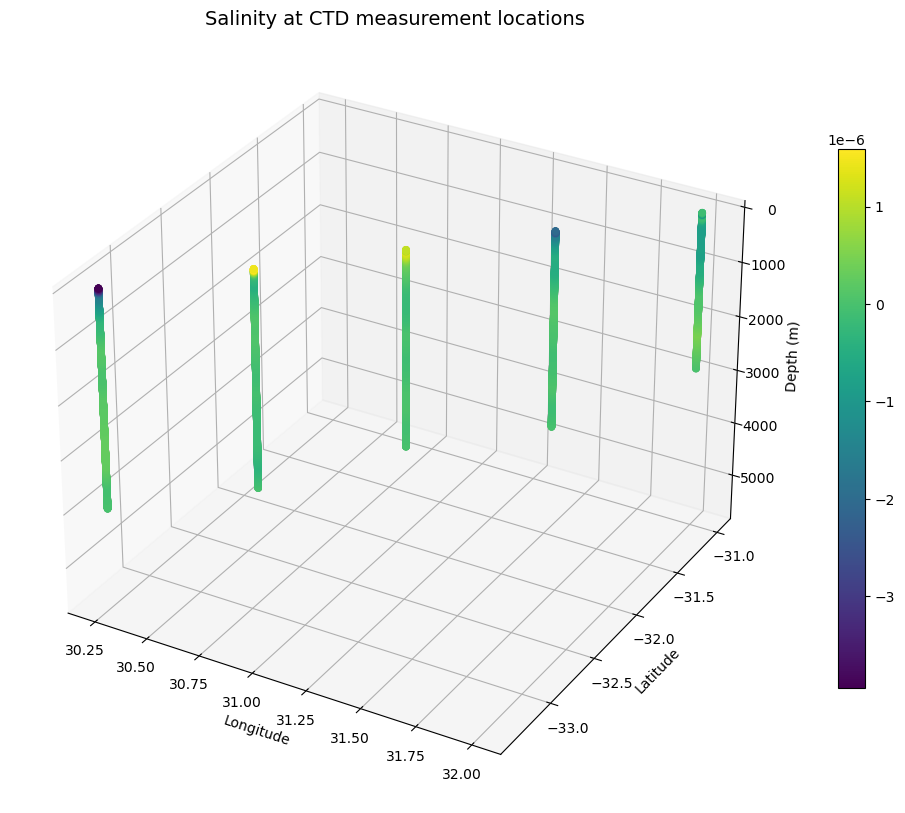

In [11]:
import matplotlib.pyplot as plt
import xarray as xr

# Open output and read to x, y, z
ds = xr.open_zarr("CTDtest.zarr")
x = ds["lon"][:].values.flatten()
y = ds["lat"][:].values.flatten()
z = ds["z"][:].values.flatten()
U = ds["U"][:].values.flatten()
V = ds["V"][:].values.flatten()
salinity = ds["salinity"][:].values.flatten()
temperature = ds["temperature"][:].values.flatten()
valid_particles = salinity>0
ds.close()

# Plot Particle depth
fig = plt.figure(figsize=(15, 10))
ax = plt.axes(projection="3d")
# cb = ax.scatter(x, y, z, c=salinity, s=20, marker="o")
cb = ax.scatter(x[valid_particles], y[valid_particles], z[valid_particles], c=salinity[valid_particles], s=20, marker="o")
ax.set_title('Salinity at CTD measurement locations', size = 14)
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (m)")
ax.set_zlim(np.max(z), 0)
fig.colorbar(cb, shrink=0.7)
plt.show()